Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import time
from datetime import datetime
import csv
users = pd.read_csv('ml-users.csv')

In [2]:
# df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
# #df_interactions = pd.read_csv('ml-interactions15000.csv')

# # Do a little cleanup...
# # In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# # not happen. So, let's find that row (and others) that have this problem and remove them

# # pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# # row and the value corresponds to True/False indicating whether there is a NaN value
# isna_result = pd.isna(df_interactions['action'])

# print("Printing all rows where 'action' == NaN...")
# display(df_interactions[isna_result])
# df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# # As a test, we can again look for NaN 'action' cells
# isna_result = pd.isna(df_interactions['action'])
# print("Printing all rows where 'action' == NaN... there should be no rows")
# display(df_interactions[isna_result])

# small represents the first 50000 actions logged to be able to test a smaller subset
# small= df_interactions[:50000]

Printing all rows where 'action' == NaN...


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id
18502779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing all rows where 'action' == NaN... there should be no rows


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id


In [68]:
# Takes in the row and appends the row into the given file
def file_appender(row, created, user_info):
    if user_info not in created:
        with open('{0}.csv'.format(user_info), 'w', newline = '') as new_user:
            writer = csv.writer(new_user)
            created.append(user_info)
            writer.writerow(header)
    with open('{0}.csv'.format(user_info), 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(row)
    return created

In [69]:
# Parses through the csv and creates new csv for every user_id & event
with open('ml-interactions.csv', newline = '') as data:
    reader = csv.reader(data)
    header = []
    users_created = []
    events_created = []
    for row in reader:
        if row[1] == 'user_id':
            header = row
        else:
            user_id = row[1]
            current_event = row[4]
            users_created = file_appender(row, users_created, user_id)
            events_created = file_appender(row, events_created, current_event)

In [215]:
# parses through each user's csv and figures out how many unique panos and missions seen
user_panos = {}
user_missions = {}
for current_user in users['user_id']:
    df_current = pd.read_csv('{0}.csv'.format(current_user))
    user_panos[current_user] = df_current['gsv_panorama_id'].nunique()
    user_missions[current_user] = df_current['mission_id'].nunique()
df_current = None

In [3]:
# # This fucntion iterates over the desired dataset and returns all of the logged events
# # that contains the desired action
# def find_action(args, use_subset = False):        
#     for index, word in enumerate(args):  
#         if use_subset:
#             if index == 0:
#                 df_information = small[small['action'].str.contains(word)]
#             else:
#                 frames = [df_information, small[small['action'].str.contains(word)]]
#                 df_information = pd.concat(frames)
#         else:
#             if index == 0:
#                 df_information = df_interactions[df_interactions['action'].str.contains(word)]
#             else:
#                 frames = [df_information, df_interactions[df_interactions['action'].str.contains(word)]]
#                 df_information = pd.concat(frames)
#     return df_information

In [82]:
# Used to create a correlation between accuracy and the info type that was given
# It accepts a string for the actions that will be used to record the info type
# graph_type determines how the information is shown and multi_plot determines if it can
# be shows in per panos & per mission
def counting_graph (info_type, graph_type, multi_plot, action):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users[' accuracy'][index]
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, multi_plot)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [99]:
# In progress
def range_graph(info_type, graph_type, action):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        current_min = df_actions_grouped.get_group(current_id).min()
        current_max = df_actions_grouped.get_group(current_id).max()
        current_accuracy = users[' accuracy'][index]
        user_information[current_id] = current_max - current_min, current_accuracy
    if graph_type == 'scatter_plot' :
        scatter_plot(info_type, user_information, False)

In [251]:
# Determines the average time it takes for a certain action to occur per second and per
# either panos or mission
# The type of information is found using the action logged
def time_graph(info_type, action):
    df_info = pd.read_csv('{0}.csv'.format(action))
    df_per_pano = df_info.groupby(['user_id', 'gsv_panorama_id'])
#     df_per_mission = df_info.groupby(['user_id','mission_id'])
    user_info = {}
    current_group_times = []
    for name,group_pano in df_per_pano:
        for current_datetime in group_pano['timestamp']:
            current_group_times.append(parser.parse(current_datetime))
        if name[0] in user_info:
            user_info[name[0]] = user_info[name[0]][0] + (max(current_group_times) - min(current_group_times)).total_seconds(), 0
        else:
            user_info[name[0]] = (max(current_group_times) - min(current_group_times)).total_seconds(), 0
#     for name,group_mission in df_per_mission:
#         for current_datetime in group_mission['timestamp']:
#             current_group_times.append(parser.parse(current_datetime))
#         user_info[name[0]][1] = user_info[name[0]][1] + (max(current_group_times) - min(current_group_times)).total_seconds()
#     time_scatter_plot(info_type, user_info)
    display(user_info)

In [322]:
# Currently unable to retrieve a specific value of certain index from a series
def time_graph(info_type, action):
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    current_pano_times = []
    current_mission_times = []
    current_pano = ''
    current_mission = ''
    pano_time_total = 0
    mission_time_total = 0
    count = 0
    for name, current_group in df_actions_grouped:
        for index, time in enumerate(current_group['timestamp']):
            if current_group['gsv_panorama_id'][index] != current_pano:
                if len(current_pano_times) > 0:
                    pano_time_total = pano_time_total + (max(current_pano_times) - min(current_pano_times)).total_seconds()
                current_pano_times = parser.parse(time)
                current_pano = current_group['gsv_panorama_id'][index]
                
            else:
                current_pano_times.append(parser.parse(time))
            if current_times['mission_id'][index] != current_mission:
                if len(current_mission_times) > 0:
                    mission_time_total = mission_time_total + (max(current_mission_times) - min(current_mission_times)).total_seconds()
                current_mission_times = entry[index]
                current_mission = current_times['mission_id'][index]
            else:
                current_mission_times.append(parser.parse(entry['timestamp']))        
    #time_scatter_plot(info_type)

In [254]:
# Creates a scatter plot relating accuracy and the occurance of an action per second per
# panos or mission
def time_scatter_plot(info_type):
    f, axs = plt.subplots(1,2,figsize=(12,4))
    plt.subplot(122)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type + ' per second per Pano')
    for index, entry in enumerate(user_panos.keys()):
        user_info = user_panos.get(entry)
        info = float(user_info)
        accuracy = users[' accuracy'][index]
        plt.plot(info, accuracy, '.', color = 'blue')
    plt.subplot(121)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type + ' per second per Mission Started')
    for index, entry in enumerate(user_missions.keys()):
        user_info = user_missions.get(entry)
        info = float(user_info)
        accuracy = users[' accuracy'][index]
        plt.plot(info, accuracy, '.', color = 'blue')

In [126]:
# Creates a scatter plot of the information given, if multi_plot is true then it is also
# divided by the number of unique panos seens and missions started
def scatter_plot(info_type, user_information, multi_plot):
    if multi_plot:
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_panos[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_missions[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(131)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        plt.plot(info, accuracy, '.', color = 'blue')

In [87]:
#Creates a histogram counting the occurances of a certain type of information
def histogram(info_type, user_information):
    plt.hist(user_information) 
    plt.xlabel(info_type)
    plt.ylabel('Count')

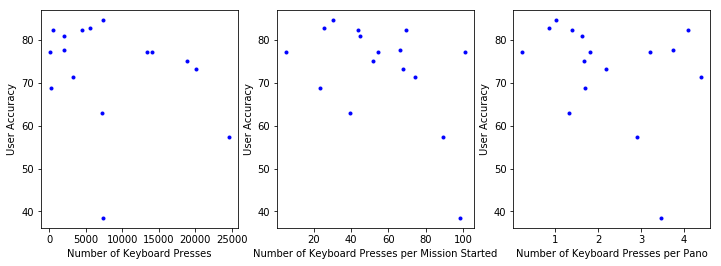

In [88]:
# Counts the number of keyboard presses
counting_graph('Number of Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown')

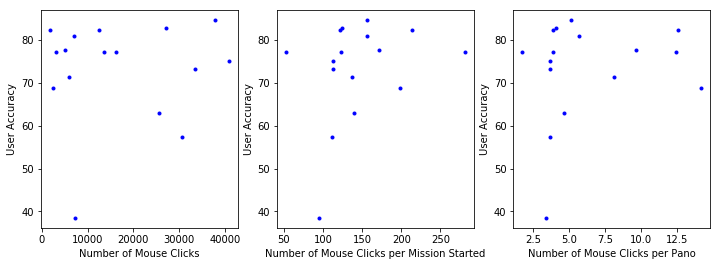

In [89]:
# Counts the number of mouse clicks
counting_graph('Number of Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown')

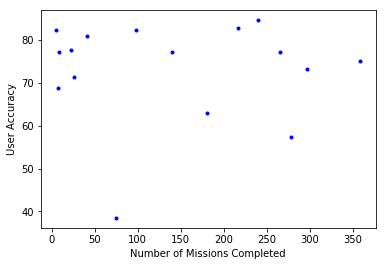

In [90]:
# Counts the number of missions completed
counting_graph('Number of Missions Completed', 'scatter_plot', False, 'MissionComplete')

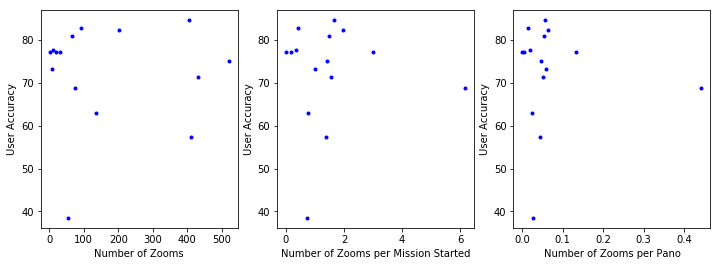

In [91]:
# Counts the number of zooms
counting_graph('Number of Zooms', 'scatter_plot', True, 'Click_ZoomIn')

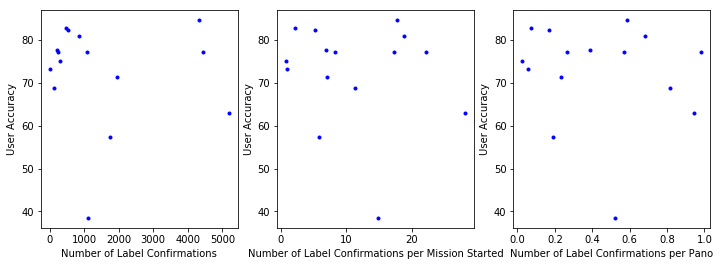

In [116]:
# Counts the number of Labels confirmations based off of clicking the OK button
counting_graph('Number of Label Confirmations', 'scatter_plot', True, 'ContextMenu_OKButtonClick')

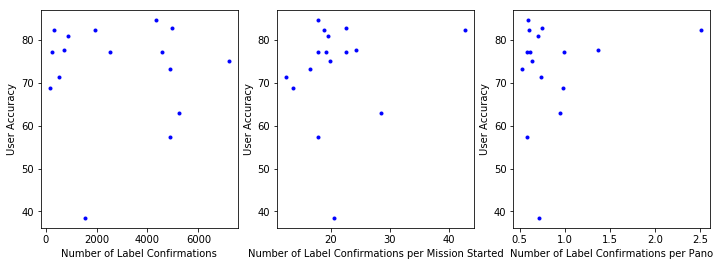

In [113]:
# Counts the number of Label Confirmation based off of closing the context window
# I am currently unsure whether this one or the one above would be a more accurate measure
# of labels done and what the other would represent
#counting_graph('Number of Label Confirmations', 'scatter_plot', True, 'ContextMenu_Close')
counting_graph('Number of Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling')

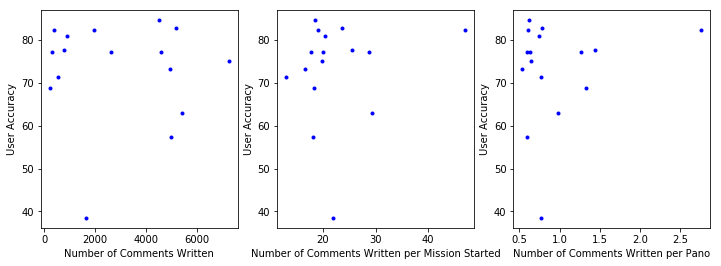

In [127]:
# Counts the number of Comments Written
# Unsure if measuring the blur of the text box is an accurate representation of comments written
counting_graph('Number of Comments Written', 'scatter_plot', True, 'ContextMenu_TextBoxBlur')

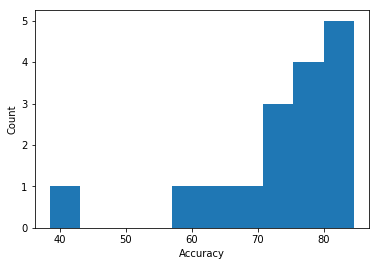

In [96]:
# Counts the number of users with different accuracies
histogram('Accuracy', users[' accuracy'])

In [324]:
# Counts the number of mouse clicks per second
time_graph('Number of Mouse Clicks', 'LowLevelEvent_mousedown')

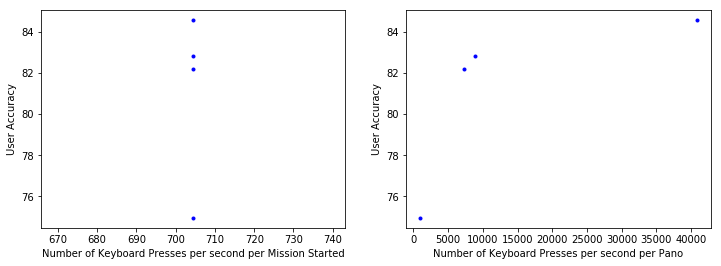

In [19]:
# Counts the number of keyboard presses per second
time_graph('Number of Keyboard Presses', 'LowLevelEvent_keydown')

In [128]:
# # Counts the number of comments written

# user_information = {}
# df_comments = pd.read_csv('{0}.csv'.format('ContextMenu_TextBoxBlur'))
# df_window_closes = pd.read_csv('{0}.csv'.format('ContextMenu_Close'))
# df_comments_grouped = df_comments.groupby(['user_id'])
# df_window_closes_grouped = df_window_closes.groupby(['user_id'])
# for index, current_id in enumerate(df_comments_grouped.groups):
#     user_information[current_id] = len(df_comments_grouped.get_group(current_id)), users[' accuracy'][index]
# scatter_plot('Comments Written', user_information, True)